## Plot loop of clouds from .zarr file

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import geogif

In [2]:
zarr_path = '/storage/cdalden/goes/goes16/2023/'
zarr_file = '1june.zarr'

ds = xr.open_zarr(zarr_path + zarr_file)

# Define the bounds
lat_min, lat_max = 37, 41
lon_min, lon_max = -109, -104

# Create latitude and longitude arrays based on the bounds and the dimensions of the dataset
lat = np.linspace(lat_min, lat_max, ds.dims['y'])
lon = np.linspace(lon_min, lon_max, ds.dims['x'])

# Assign the latitude and longitude coordinates to the dataset
ds = ds.assign_coords(lon=('x', lon), lat=('y', lat))

# Verify the dataset
print(ds)

<xarray.Dataset> Size: 133MB
Dimensions:                                           (t: 288,
                                                       num_star_looks: 24,
                                                       y: 160, x: 241,
                                                       number_of_harmonization_coefficients: 3,
                                                       number_of_image_bounds: 2,
                                                       band: 1,
                                                       number_of_time_bounds: 2)
Coordinates:
    band_wavelength_star_look                         (num_star_looks) float32 96B dask.array<chunksize=(24,), meta=np.ndarray>
    y_image                                           float32 4B ...
  * y                                                 (y) float64 1kB 0.1092 ...
    t_star_look                                       (num_star_looks) datetime64[ns] 192B dask.array<chunksize=(24,), meta=np.ndarray>
    x_image 

/tmp/ipykernel_23072/3743806464.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  lat = np.linspace(lat_min, lat_max, ds.dims['y'])
/tmp/ipykernel_23072/3743806464.py:12: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  lon = np.linspace(lon_min, lon_max, ds.dims['x'])


In [22]:
variable = 'Rad'
# select our variable of interest
da = ds[variable]

# Create the gif animation with coordinates
gif_bytes = geogif.dgif(
    da,
    fps=20,
    cmap="Greys_r",
    date_format="%Y-%m-%d %H:%M:%S",
    date_position="ul",
    bytes=True,
).compute()

# write gif to file
with open(f"test1.gif", "wb") as f:
    f.write(gif_bytes)


### Plot DEM with domain

In [1]:
import requests
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource

# Your OpenTopography API key
OPENTOPO_API_KEY = "41d14aae7e761c0de3e8f99aa4fd24d9"

# Define the bounding box for the area of interest
min_lon, min_lat = -107.25, 38.5
max_lon, max_lat = -106.5, 39.25

# OpenTopography API URL
url = "https://portal.opentopography.org/API/globaldem"

# Parameters for the API request
params = {
    'demtype': 'SRTMGL1',  # You can choose other DEM types like 'SRTMGL3', 'AW3D30', etc.
    'south': min_lat,
    'north': max_lat,
    'west': min_lon,
    'east': max_lon,
    'outputFormat': 'GTiff',
    'API_Key': OPENTOPO_API_KEY
}

# Make the API request
response = requests.get(url, params=params)

# Save the DEM file
dem_path = 'dem.tif'
with open(dem_path, 'wb') as f:
    f.write(response.content)

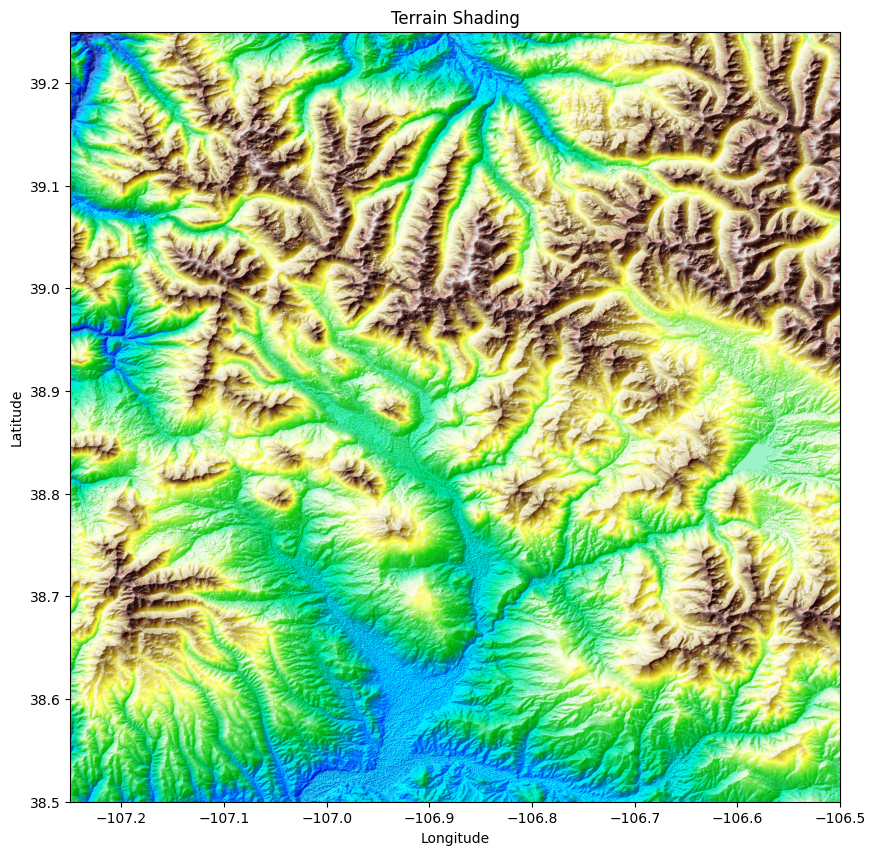

In [2]:
# Open the DEM file
with rasterio.open(dem_path) as src:
    # Calculate the window to read based on the desired coordinates
    window = rasterio.windows.from_bounds(min_lon, min_lat, max_lon, max_lat, transform=src.transform)
    dem = src.read(1, window=window)
    transform = src.window_transform(window)

# Create a light source object
ls = LightSource(azdeg=315, altdeg=45)

# Shade the DEM data
shaded_dem = ls.shade(dem, cmap=plt.cm.terrain, blend_mode='overlay')

# Plot the shaded DEM
plt.figure(figsize=(10, 10))
plt.imshow(shaded_dem, extent=(transform[2], transform[2] + transform[0] * dem.shape[1], transform[5] + transform[4] * dem.shape[0], transform[5]))
plt.title('Terrain Shading')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()